# Task 2: Apply Perturbations to ALS Genes and Embed (Geneformer V2)


In [1]:
# Ensure repo root is on sys.path for `utils` imports
from pathlib import Path
import sys
repo_root = Path.cwd().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
print('Added to sys.path:', repo_root)


Added to sys.path: /cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer


In [2]:
import os
os.environ["PIP_CACHE_DIR"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache"
os.environ["HF_HOME"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/huggingface"
os.environ["TRANSFORMERS_CACHE"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/transformers"

In [3]:
# export LD_LIBRARY_PATH="/cs/student/projects1/aibh/2024/rmaheswa/python-3.10/lib:$LD_LIBRARY_PATH"
# export JUPYTER_PATH="/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/helical-env-310-share"

In [4]:
# Environment variables are now automatically set by the virtual environment
# Verify PyTorch GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU count: 1
Current GPU: NVIDIA GeForce RTX 3090 Ti
GPU memory: 25.3 GB


In [5]:
# Configuration for memory management
# Set SUBSET_SIZE to None to use full dataset, or a number to use subset
SUBSET_SIZE = 5000  # Use 5000 cells per group for testing
BATCH_SIZE = 16     # Batch size for Geneformer embeddings
TOP_K = 4096        # Number of top genes to use for ranking

print(f"Configuration:")
print(f"  SUBSET_SIZE: {SUBSET_SIZE} (None = full dataset)")
print(f"  BATCH_SIZE: {BATCH_SIZE}")
print(f"  TOP_K: {TOP_K}")
print(f"  GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


Configuration:
  SUBSET_SIZE: 5000 (None = full dataset)
  BATCH_SIZE: 16
  TOP_K: 4096
  GPU available: True
  GPU memory: 25.3 GB


In [6]:
from pathlib import Path
import numpy as np
import anndata as ad
import gc
from utils.io import ensure_dirs
from utils.perturb import batch_perturb
from utils.geneformer_helpers import GFEmbedder

from importlib import reload
import utils.geneformer_helpers as gfh
gfh = reload(gfh)
from utils.geneformer_helpers import GFEmbedder  # re-import after reload

import geneformer, inspect
from utils.plotting import umap_2d, plot_umap

/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/.venv-gf310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/.venv-gf310/lib/python3.10/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [7]:


ensure_dirs()
AD_DIR = Path('/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/adata')
EMB_DIR = Path('/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/embeddings')
FIG_DIR = Path('/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/figs')

EMB_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load baseline AnnData
baseline_path = AD_DIR / 'baseline.h5ad'
if not baseline_path.exists():
    raise FileNotFoundError("Missing data/adata/baseline.h5ad. Run: make prep")

print("Loading baseline data...")
adata = ad.read_h5ad(baseline_path)
print(f"Loaded AnnData: {adata.n_obs} cells, {adata.n_vars} genes")

# Use configuration from previous cell
print(f"Using subset size: {SUBSET_SIZE} cells per group (set SUBSET_SIZE=None for full dataset)")

als_genes = ["C9orf72","SOD1","TARDBP","FUS","TBK1","NEK1"]

# Build gene_sets with _up/_down variants
up_sets = {f"{g}_up": [g] for g in als_genes}
down_sets = {f"{g}_down": [g] for g in als_genes}

# Split healthy vs ALS by obs labels
# Check for Condition column (capital C) first, then fall back to Group
if 'Condition' in adata.obs.columns:
    print("Using 'Condition' column for grouping")
    print(f"Available conditions: {adata.obs['Condition'].value_counts().to_dict()}")
    # PN = presumably healthy/control, ALS = disease
    healthy = adata[adata.obs['Condition'] == 'PN'].copy()
    als = adata[adata.obs['Condition'] == 'ALS'].copy()
elif 'Group' in adata.obs.columns:
    print("Using 'Group' column for grouping")
    print(f"Available groups: {adata.obs['Group'].value_counts().to_dict()}")
    # PN = presumably healthy/control, SALS = Sporadic ALS
    healthy = adata[adata.obs['Group'] == 'PN'].copy()
    als = adata[adata.obs['Group'] == 'SALS'].copy()
else:
    raise ValueError("Required obs column 'Condition' or 'Group' not found. Please add condition labels to baseline AnnData.")

print(f"Healthy cells: {healthy.n_obs}")
print(f"ALS cells: {als.n_obs}")

# Apply subsetting if specified
if SUBSET_SIZE is not None:
    print(f"Subsetting to {SUBSET_SIZE} cells per group...")
    if healthy.n_obs > SUBSET_SIZE:
        healthy = healthy[:SUBSET_SIZE].copy()
    if als.n_obs > SUBSET_SIZE:
        als = als[:SUBSET_SIZE].copy()
    print(f"After subsetting - Healthy: {healthy.n_obs}, ALS: {als.n_obs}")

# Clear memory
gc.collect()

print("Applying perturbations...")
# a) healthy -> ALS-like (up)
pert_rank_up = batch_perturb(healthy, up_sets, mode='rank', direction='up', delta_percentile=0.15)
# b) ALS -> rescue (down)
pert_rank_down = batch_perturb(als, down_sets, mode='rank', direction='down', delta_percentile=0.15)

print("✓ Perturbations complete")
gc.collect()

# Geneformer embeddings
print("Initializing Geneformer embedder...")
embedder = GFEmbedder()

# Sanity: tokenizer vocab coverage on this dataset
try:
    syms = healthy.var.get("gene_symbol", healthy.var_names).astype(str)
    mapped = [s if s.upper().startswith("ENSG") else embedder.gene_name_to_ensembl.get(s.upper(), None) for s in syms]
    present = [g for g in mapped if (g is not None) and (g in embedder.tokenizer.gene_token_dict)]
    cov = len(present) / max(1, len(mapped))
    print(f"Tokenizer coverage: {len(present)}/{len(mapped)} ({cov:.1%})")
except Exception as e:
    print("Tokenizer coverage check skipped:", e)

print("Generating embeddings for healthy baseline...")
healthy_tokens = embedder.adata_to_rank_tokens(healthy, top_k=TOP_K)
healthy_emb = embedder.get_cls_embeddings(healthy_tokens, batch_size=BATCH_SIZE)
np.savez(EMB_DIR / 'healthy_base.npz', arr=healthy_emb)
print(f"✓ Saved healthy baseline embeddings: {healthy_emb.shape}")
del healthy_tokens
gc.collect()

print("Generating embeddings for ALS baseline...")
als_tokens = embedder.adata_to_rank_tokens(als, top_k=TOP_K)
als_emb = embedder.get_cls_embeddings(als_tokens, batch_size=BATCH_SIZE)
np.savez(EMB_DIR / 'als_base.npz', arr=als_emb)
print(f"✓ Saved ALS baseline embeddings: {als_emb.shape}")
del als_tokens
gc.collect()

print("Generating embeddings for healthy perturbations...")
for name, adx in pert_rank_up.items():
    print(f"  Processing {name}...")
    toks = embedder.adata_to_rank_tokens(adx, top_k=TOP_K)
    emb = embedder.get_cls_embeddings(toks, batch_size=BATCH_SIZE)
    np.savez(EMB_DIR / f'healthy_{name}.npz', arr=emb)
    print(f"  ✓ Saved {name}: {emb.shape}")
    del toks, emb
    gc.collect()

print("Generating embeddings for ALS perturbations...")
for name, adx in pert_rank_down.items():
    print(f"  Processing {name}...")
    toks = embedder.adata_to_rank_tokens(adx, top_k=TOP_K)
    emb = embedder.get_cls_embeddings(toks, batch_size=BATCH_SIZE)
    np.savez(EMB_DIR / f'als_{name}.npz', arr=emb)
    print(f"  ✓ Saved {name}: {emb.shape}")
    del toks, emb
    gc.collect()

# Optional: quick UMAP preview across subsets
stack = np.vstack([healthy_emb, als_emb])
labels = ['healthy']*len(healthy_emb) + ['als']*len(als_emb)
pts = umap_2d(stack)
plot_umap(pts, labels, 'Task2: Healthy vs ALS (baseline)', str(FIG_DIR / 'task2_embedding_snapshot.png'))

print('Saved embeddings to /cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/embeddings and snapshot figure to /cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/figs.')


Loading baseline data...
Loaded AnnData: 112014 cells, 22026 genes
Using subset size: 5000 cells per group (set SUBSET_SIZE=None for full dataset)
Using 'Condition' column for grouping
Available conditions: {'ALS': 66960, 'PN': 45054}
Healthy cells: 45054
ALS cells: 66960
Subsetting to 5000 cells per group...
After subsetting - Healthy: 5000, ALS: 5000
Applying perturbations...
✓ Perturbations complete
Initializing Geneformer embedder...


Some weights of BertModel were not initialized from the model checkpoint at ctheodoris/Geneformer and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizer coverage: 17986/22026 (81.7%)
Generating embeddings for healthy baseline...
✓ Saved healthy baseline embeddings: (5000, 768)
Generating embeddings for ALS baseline...
✓ Saved ALS baseline embeddings: (5000, 768)
Generating embeddings for healthy perturbations...
  Processing C9orf72_up...
  ✓ Saved C9orf72_up: (5000, 768)
  Processing SOD1_up...
  ✓ Saved SOD1_up: (5000, 768)
  Processing TARDBP_up...
  ✓ Saved TARDBP_up: (5000, 768)
  Processing FUS_up...
  ✓ Saved FUS_up: (5000, 768)
  Processing TBK1_up...
  ✓ Saved TBK1_up: (5000, 768)
  Processing NEK1_up...
  ✓ Saved NEK1_up: (5000, 768)
Generating embeddings for ALS perturbations...
  Processing C9orf72_down...
  ✓ Saved C9orf72_down: (5000, 768)
  Processing SOD1_down...
  ✓ Saved SOD1_down: (5000, 768)
  Processing TARDBP_down...
  ✓ Saved TARDBP_down: (5000, 768)
  Processing FUS_down...
  ✓ Saved FUS_down: (5000, 768)
  Processing TBK1_down...
  ✓ Saved TBK1_down: (5000, 768)
  Processing NEK1_down...
  ✓ Saved NEK

/cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/.venv-gf310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved embeddings to /cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/embeddings and snapshot figure to /cs/student/projects1/aibh/2024/rmaheswa/Helical_Task/als-perturb-geneformer/als-perturb-geneformer/data/figs.


Displaying UMAP snapshot from Task 2:


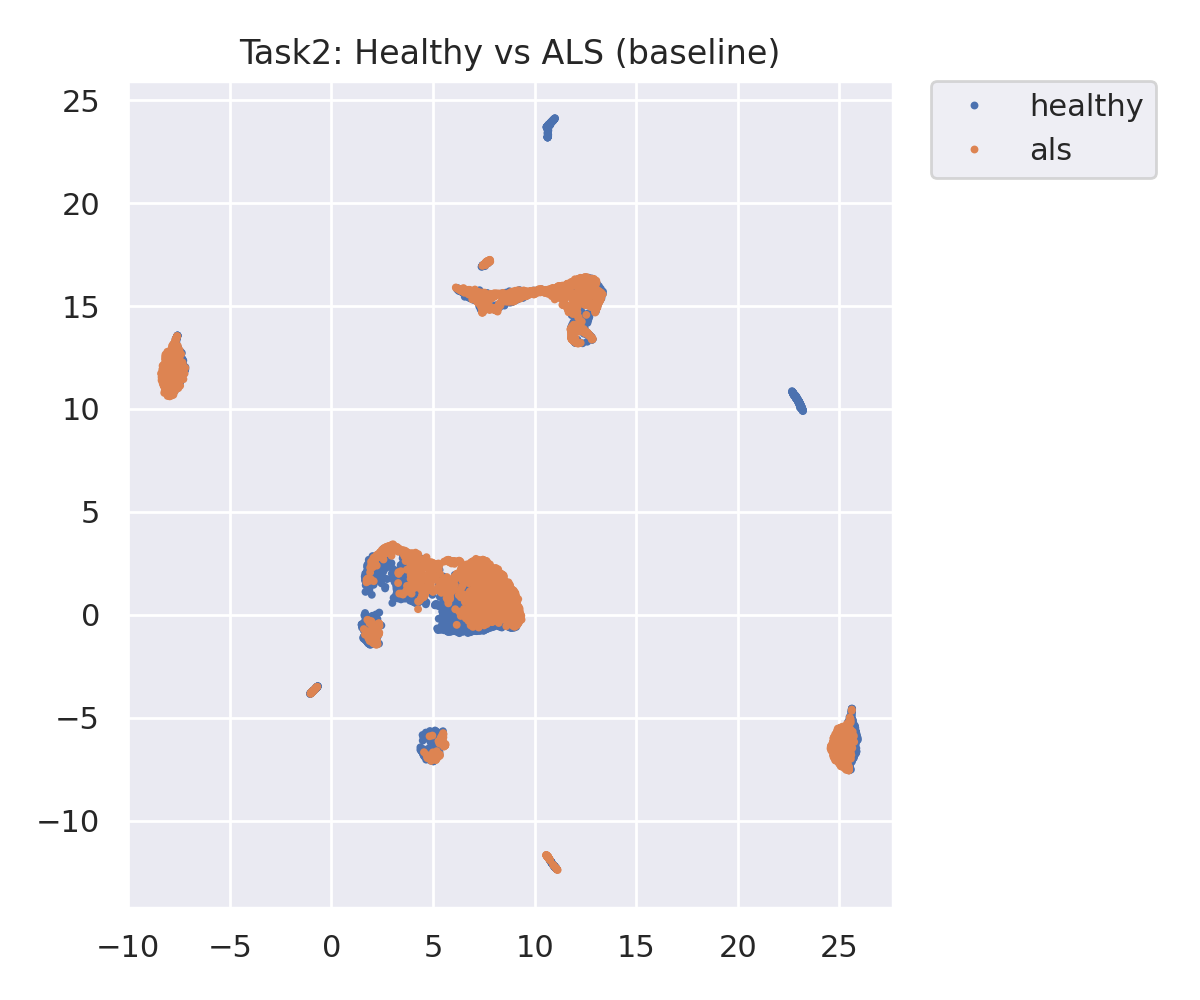

In [8]:
# Display UMAP snapshot
from IPython.display import Image, display
fig_path = FIG_DIR / 'task2_embedding_snapshot.png'
if fig_path.exists():
    print(f"Displaying UMAP snapshot from Task 2:")
    display(Image(str(fig_path)))
else:
    print(f"Figure not found at: {fig_path}")